## MNIST Data

In [ ]:
using MLDatasets
using Plots
using Images
using StatsBase
using BSON, JSON
using Flux
using Flux: onecold
using Random
using Printf
using ProgressMeter

In [ ]:
using Revise
using DenoisingDiffusion 
using DenoisingDiffusion: train!, split_validation

In [ ]:
include("utilities.jl");

## Load

In [ ]:
data_directory="path\\to\\MNIST"
trainset = MNIST(Float32, :train, dir=data_directory)
testset = MNIST(Float32, :test, dir=data_directory)

display(trainset)
display(testset)

dataset MNIST:
  metadata    =>    Dict{String, Any} with 3 entries
  split       =>    :train
  features    =>    28×28×60000 Array{Float32, 3}
  targets     =>    60000-element Vector{Int64}

dataset MNIST:
  metadata    =>    Dict{String, Any} with 3 entries
  split       =>    :test
  features    =>    28×28×10000 Array{Float32, 3}
  targets     =>    10000-element Vector{Int64}

In [ ]:
for pair in trainset.metadata
    println(pair[1], " => ", pair[2])
end

n_observations => 60000
targets_path => C:\Users\sinai\Documents\Projects\datasets\MNIST\train-labels-idx1-ubyte.gz
features_path => C:\Users\sinai\Documents\Projects\datasets\MNIST\train-images-idx3-ubyte.gz


In [ ]:
X = normalize_neg_one_to_one(reshape(trainset.features, 28, 28, 1, :))
train_x, val_x = split_validation(MersenneTwister(2714), X)
val_data = Flux.DataLoader(val_x; batchsize=32, shuffle=false);

## Test

### load model

In [ ]:
directory = "../outputs/MNIST_20221016_16att"
diffusion_path = joinpath(directory, "diffusion_opt.bson");
history_path = joinpath(directory, "history.json");

In [ ]:
diffusion = BSON.load(diffusion_path)[:diffusion]
println("data shape:    $(diffusion.data_shape)")
num_timesteps = diffusion.num_timesteps
println("num timesteps: $(num_timesteps)")
diffusion.denoise_fn

data shape:    (28, 28, 1)
num timesteps: 100


UNet(
  time_embedding = Chain(
    SinusoidalPositionEmbedding(100 => 64),
    Dense(64 => 64, gelu),              # 4_160 parameters
    Dense(64 => 64),                    # 4_160 parameters
  ),
  chain = ConditionalChain(
    init = Conv((3, 3), 1 => 16, pad=1),  # 160 parameters
    down_1 = ResBlock(
      in_layers = ConvEmbed(
        embed_layers = Chain(
          NNlib.swish,
          Dense(64 => 16),              # 1_040 parameters
        ),
        conv = Conv((3, 3), 16 => 16, pad=1),  # 2_320 parameters
        norm = GroupNorm(16, 8),        # 32 parameters
        activation = NNlib.swish,
      ),
      out_layers = Chain(
        Conv((3, 3), 16 => 16, pad=1),  # 2_320 parameters
        GroupNorm(16, 8),               # 32 parameters
        NNlib.swish,
      ),
      skip_transform = identity,
    ),
    skip_1 = ConditionalSkipConnection(
      ConditionalChain(
        downsample_1 = Conv((4, 4), 16 => 16, pad=1, stride=2),  # 4_112 parameters
        down_2 

In [ ]:
history = Dict()
open(history_path, "r") do f
    global history
    history=JSON.parse(read(f, String))
end

Dict{String, Any} with 3 entries:
  "train_loss" => Any[0.202368, 0.0664656, 0.0577389, 0.052934, 0.0496523, 0.04…
  "epoch_size" => 54000
  "val_loss"   => Any[0.0784225, 0.0605865, 0.0548152, 0.0498789, 0.0472304, 0.…

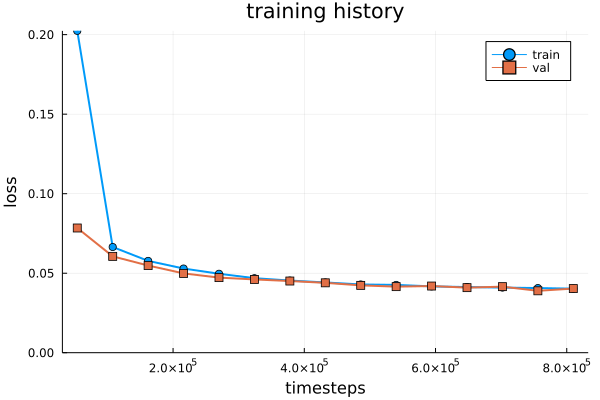

In [ ]:
timesteps = (1:length(history["train_loss"])) * history["epoch_size"]

p = plot(timesteps, history["train_loss"], 
    label="train", ylims=(0, Inf),
    title="training history",
    xlabel="timesteps",
    ylabel="loss",
    linewidth=2,
    markershape=:circle,
)
plot!(p, timesteps, history["val_loss"], label="val", linewidth=2, markershape=:square)
savefig(p, joinpath(directory, "loss.png"))
p

### validate

In [ ]:
val_loss = 0.0
@showprogress for x in val_data
    global val_loss
    val_loss += p_losses(diffusion, Flux.mse, x; to_device=cpu)
end
val_loss /= length(val_data)
@printf("\nval loss: %.5f\n", val_loss)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:55



val loss: 0.03957


### sample

In [ ]:
X0s, X0_ests = p_sample_loop_all(diffusion, 16; to_device=cpu) ;
size(X0s)

Sampling... 100%|████████████████████████████████████████| Time: 0:00:26


(28, 28, 1, 16, 100)

In [ ]:
imgs = convert2image(trainset, X0s[:, :, 1, :, end]);

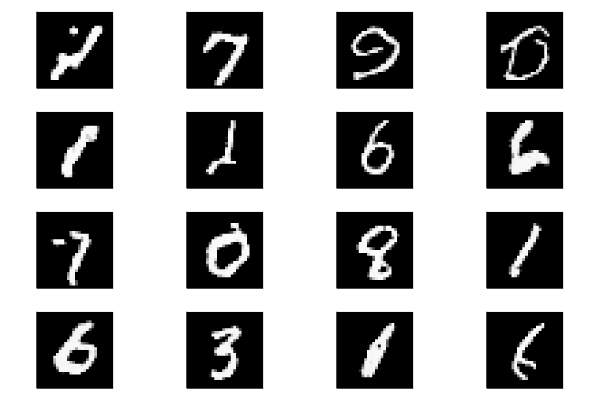

In [ ]:
p = plot([plot(imgs[:, :, i]) for i in 1:16]..., layout=(4, 4), ticks=nothing)
savefig(p, joinpath(directory, "samples_epoch=15.png"))
p

## Animations

In [ ]:
function combine(imgs::AbstractArray, nrows::Int, ncols::Int, border::Int)
    canvas = zeros(Gray, 28 * nrows + (nrows+1) * border, 28 * ncols + (ncols+1) * border)
    for i in 1:nrows
        for j in 1:ncols
            left = 28 * (i-1) + 1 + border * i 
            right = 28 * i + border * i
            top = 28 * (j - 1) + 1 + border * j
            bottom = 28 * j + border * j
            canvas[left:right, top:bottom] = imgs[:, :, ncols * (i-1) + j]
        end
    end
    canvas
end

combine (generic function with 1 method)

In [ ]:
anim_denoise = @animate for i ∈ 1:(num_timesteps + 15)
    i = i > num_timesteps ? num_timesteps : i
    imgs = convert2image(trainset, X0s[:, :, 1, :, i]);
    canavs = combine(imgs, 4, 4, 2)
    p = plot(canavs, ticks=nothing, plot_title="i=$i")
end

Animation("C:\\Users\\sinai\\AppData\\Local\\Temp\\jl_wBMsEg", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000106.png", "000107.png", "000108.png", "000109.png", "000110.png", "000111.png", "000112.png", "000113.png", "000114.png", "000115.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion\outputs\MNIST_20221016_16att\numbers_reverse.gif
└ @ Plots C:\Users\sinai\.julia\packages\Plots\1KWPG\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\sinai\\Documents\\Projects\\Julia projects\\DenoisingDiffusion\\outputs\\MNIST_20221016_16att\\numbers_reverse.gif")
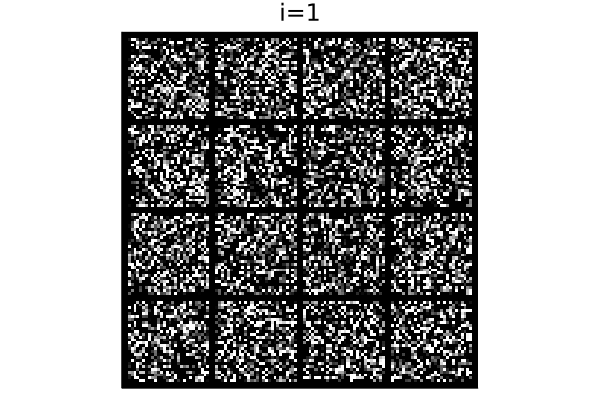

In [ ]:
gif(anim_denoise, joinpath(directory, "numbers_reverse.gif"), fps=15)

In [ ]:
anim_estimates = @animate for i ∈ 1:(num_timesteps + 15)
    i =i > num_timesteps ? num_timesteps : i
    imgs = convert2image(trainset, X0_ests[:, :, 1, :,i]);
    canavs = combine(imgs, 4, 4, 2)
    p = plot(canavs, ticks=nothing, plot_title="i=$i",)
end

Animation("C:\\Users\\sinai\\AppData\\Local\\Temp\\jl_h0ECyG", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000106.png", "000107.png", "000108.png", "000109.png", "000110.png", "000111.png", "000112.png", "000113.png", "000114.png", "000115.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion\outputs\MNIST_20221016_16att\numbers_estimate.gif
└ @ Plots C:\Users\sinai\.julia\packages\Plots\1KWPG\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\sinai\\Documents\\Projects\\Julia projects\\DenoisingDiffusion\\outputs\\MNIST_20221016_16att\\numbers_estimate.gif")
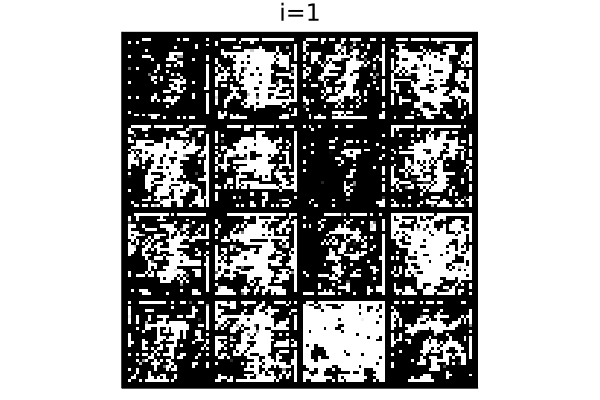

In [ ]:
gif(anim_estimates, joinpath(directory, "numbers_estimate.gif"), fps=15)

## Compare to ground truth data

closest samples

idx=8
max difference:  224.5f
min difference:   27.5f


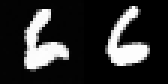

idx=13
max difference:  214.5f
min difference:   29.5f


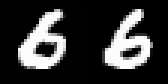

idx=14
max difference:  221.5f
min difference:   19.5f


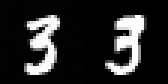

idx=6
max difference:  238.5f
min difference:   27.5f


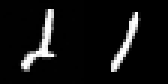

In [ ]:
for idx in sample(1:16, 4, replace=false)
    x = normalize_zero_to_one(X0s[:, :, :, idx, end]);
    min_difference = Inf
    max_difference = 0.0
    closest = 1
    for i in 1:length(trainset)
        difference = sum(abs2, x -trainset.features[:, :, i])
        if difference < min_difference
            closest = i
            min_difference = difference
        end
        max_difference = max(max_difference, difference)
    end
    println("idx=$idx")
    @printf("max difference: %4d.5f\n", max_difference)
    @printf("min difference: %4d.5f\n", min_difference)
    img_x =  convert2image(trainset, x[:, :, 1]);
    img_closest = convert2image(trainset, trainset.features[:, :, closest])
    display([img_x img_closest])
end

## Fretchet LeNet Distance

### 1) model

In [ ]:
classifier_path = "..\\outputs\\LeNet5\\model.bson"

"..\\outputs\\LeNet5\\model.bson"

In [ ]:
full_model = BSON.load(classifier_path)[:model]
classifier = full_model[1:(end - 1)]
println("classifier = " * repr("text/plain", classifier) * "\n")
head = full_model[end]
println("head = " * repr("text/plain", head))

classifier = Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(256 => 120, relu),              # 30_840 parameters
  Dense(120 => 84, relu),               # 10_164 parameters
)                   # Total: 8 arrays, 43_576 parameters, 171.422 KiB.

head = Dense(84 => 10)     # 850 parameters


### 2 ) data

In [ ]:
generate_data = false;

In [ ]:
if generate_data
    out_path = joinpath(directory, "generatedset_epoch=15.bson")
    to_device = gpu
    T = eltype(eltype(diffusion))
    x_out = Array{T}(undef,  diffusion.data_shape..., 0)
    diffusion = diffusion |> to_device

    start_time = time_ns()
    for i in 1:2
        global x_out
        println(stderr, i)
        X0 = p_sample_loop(diffusion, 500; to_device=to_device)
        X0 = cpu(X0)
        x_out = cat(x_out, X0, dims=4)
    end
    end_time = time_ns() - start_time
    println("\ndone training")
    @printf "time taken: %.2fs\n" end_time / 1e9

    BSON.bson(out_path, Dict(:generatedset=>x_out))

    diffusion = diffusion |> cpu ;
    X_generated = x_out
end

In [ ]:
## load
generated_path = joinpath(directory, "generatedset_epoch=15_ddim=20_eta=1.bson");
X_generated = BSON.load(generated_path)[:generatedset];

In [ ]:
n_samples = min(size(X_generated, 4), length(testset))
println("n_samples: ", n_samples)
rng = MersenneTwister(314159)
idxs = randperm(rng, length(trainset))[1:n_samples]

X_train = trainset.features[:, :, idxs];
X_train = reshape(X_train, 28, 28, 1, :);

idxs = randperm(rng, length(testset))[1:n_samples]
X_test = testset.features[:, :, idxs];
X_test = reshape(X_test, 28, 28, 1, :);

X_rand = randn(Float32, 28, 28, 1, n_samples);
clamp!(X_rand, -1, 1);

X_generated = X_generated[:, :, :, 1:n_samples] ;

n_samples: 10000


In [ ]:
for i in 1:n_samples
    global X_generated
    X_generated[:, :, :, i] = normalize_zero_to_one(X_generated[:, :, :, i])
end
for i in 1:n_samples
    global X_rand
    X_rand[:, :, :, i] = normalize_zero_to_one(X_rand[:, :, :, i])
end

### 3) Statistics

In [ ]:
stats = Dict(
    :test => Dict{Symbol, Any}(),
    :train => Dict{Symbol, Any}(),
    :random => Dict{Symbol, Any}(),
    :generated => Dict{Symbol, Any}(),
)

Dict{Symbol, Dict{Symbol, Any}} with 4 entries:
  :generated => Dict()
  :test      => Dict()
  :train     => Dict()
  :random    => Dict()

In [ ]:
activations = Dict()
@time activations[:test] = classifier(X_test);
println(size(activations[:test]))
@time activations[:train] = classifier(X_train);
@time activations[:random] = classifier(X_rand);
@time activations[:generated] = classifier(X_generated);

  3.068159 seconds (1.87 M allocations: 501.840 MiB, 2.17% gc time, 61.66% compilation time)
(84, 10000)
  1.202250 seconds (124 allocations: 400.186 MiB, 10.70% gc time)
  1.657258 seconds (119 allocations: 400.186 MiB, 7.93% gc time)
  0.973999 seconds (118 allocations: 400.185 MiB)


In [ ]:
include("utilities.jl");

 $$ FLD = ||\mu_1 - \mu_2||^2 + tr\left(\Sigma_1 + \Sigma_2 - 2\sqrt{\Sigma_1\Sigma_2}\right) $$

In [ ]:
μ_test = mean(activations[:test]; dims=2)
Σ_test = cov(activations[:test]; dims=2, corrected=true)
for dataset in [:test, :train, :random, :generated]
    println(stderr, dataset)
    μ = mean(activations[dataset]; dims=2)
    Σ = cov(activations[dataset]; dims=2, corrected=true)
    fld = gaussian_fretchet_distance(μ_test, Σ_test, μ, Σ)
    stats[dataset][:μ] = μ
    stats[dataset][:Σ] = Σ
    stats[dataset][:fld] = fld
end

test
train
random
generated


In [ ]:
@printf("FLD self:      %8.4f\n", stats[:test][:fld])
@printf("FLD train:     %8.4f\n", stats[:train][:fld])
@printf("FLD generated: %8.4f\n", stats[:generated][:fld])
@printf("FLD random:    %8.4f\n", stats[:random][:fld])

FLD self:        0.0001
FLD train:       0.4706
FLD generated:  26.3079
FLD random:    337.8815


### 4)  classifier predictions

In [ ]:
for dataset in [:test, :train, :random, :generated]
    logits = head(activations[dataset])
    probs = sigmoid(logits)
    y = onecold(logits, 0:9)
    stats[dataset][:y] = y
    stats[dataset][:counts] = [count(x->x==label, y ) for label in 0:9]
    stats[dataset][:probs] = probs
    stats[dataset][:probs_y] = vec(maximum(probs, dims=1))
end

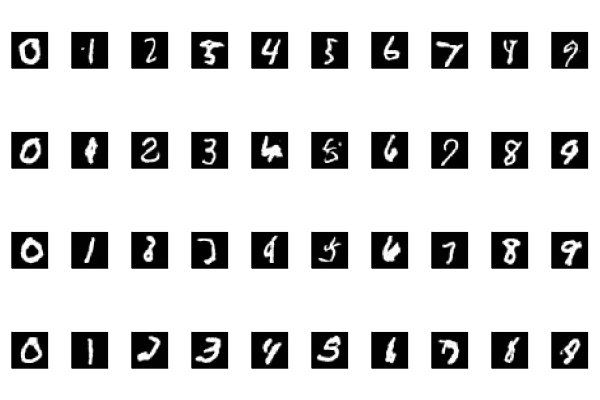

In [ ]:
nrows = 4
canvases = []
targets = stats[:generated][:y]
for label in 0:9
    idxs = (1:size(X_generated, 4))[targets .== label]
    for idx in rand(idxs, nrows)
        img = convert2image(trainset, X_generated[:, :, 1, idx])
        push!(canvases, plot(img))
    end
end
canvases = [canvases[nrows * j + i] for i in 1:nrows for j in 0:9]

plot(canvases..., layout=(nrows, 10), ticks=nothing)

In [ ]:
mean_imgs_gen = []
for label in 0:9
    idxs = stats[:generated][:y] .== label
    x_mean = mean(X_generated[:, :, 1, idxs], dims=3)
    mean_img = convert2image(trainset, x_mean)
    push!(mean_imgs_gen, mean_img)
end

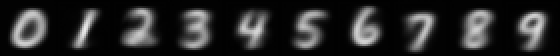

In [ ]:
imgs = cat(mean_imgs_gen..., dims=2)
imgs[:, :, 1]

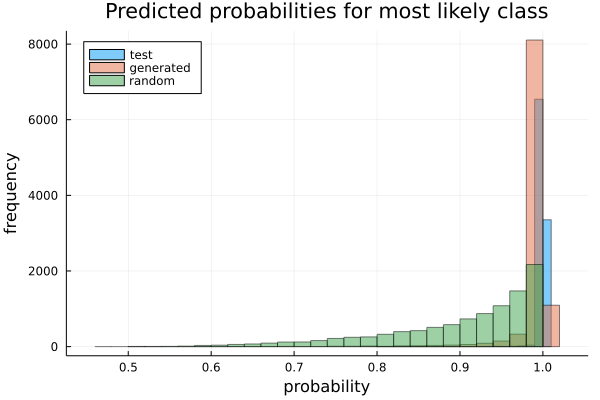

In [ ]:
nbins = 30
histogram(stats[:test][:probs_y], bins=nbins, alpha=0.5, label="test")
histogram!(stats[:generated][:probs_y], bins=nbins, alpha=0.5, label="generated")
histogram!(stats[:random][:probs_y], bins=nbins, alpha=0.5, label="random")
p = plot!(legend=:topleft, ylabel="frequency", xlabel="probability", title="Predicted probabilities for most likely class")
savefig(p, joinpath(directory, "LeNet_probabilities.png"))
p

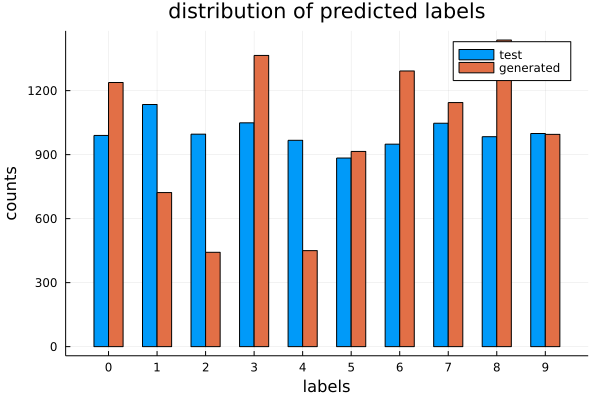

In [ ]:
width = 0.3
x1  = (1-width/2):1:(10-width/2)
x2  = (1+width/2):1:(10+width/2)
bar(x1, stats[:test][:counts], bar_width=width, label="test")
bar!(x2, stats[:generated][:counts], bar_width=width, label="generated")
p = plot!(ylabel="counts", xlabel="labels", xticks=(1:10, 0:9), title="distribution of predicted labels")
savefig(p, joinpath(directory, "LeNet_label_counts.png"))
p